In [1]:
import numpy as np 
import matplotlib.pyplot as plt
import pandas as pd
import random
import gradio as gr
import time
import json

In [2]:
data_eiffel=np.load("Data/Eiffel Tower.npy",mmap_mode=None, allow_pickle=False, fix_imports=True, encoding='ASCII')
data_airplane=np.load("Data/airplane.npy",mmap_mode=None, allow_pickle=False, fix_imports=True, encoding='ASCII')
data_apple=np.load("Data/apple.npy",mmap_mode=None, allow_pickle=False, fix_imports=True, encoding='ASCII')
data_bee=np.load("Data/bee.npy",mmap_mode=None, allow_pickle=False, fix_imports=True, encoding='ASCII')
data_cake=np.load("Data/cake.npy",mmap_mode=None, allow_pickle=False, fix_imports=True, encoding='ASCII')
data_car=np.load("Data/car.npy",mmap_mode=None, allow_pickle=False, fix_imports=True, encoding='ASCII')
data_church=np.load("Data/church.npy",mmap_mode=None, allow_pickle=False, fix_imports=True, encoding='ASCII')
data_dolphin=np.load("Data/dolphin.npy",mmap_mode=None, allow_pickle=False, fix_imports=True, encoding='ASCII')
data_dragon=np.load("Data/dragon.npy",mmap_mode=None, allow_pickle=False, fix_imports=True, encoding='ASCII')
data_house=np.load("Data/house.npy",mmap_mode=None, allow_pickle=False, fix_imports=True, encoding='ASCII')

In [3]:
data_eiffel=data_eiffel[0:10000,:]
data_airplane=data_airplane[0:20000,:]
data_apple=data_apple[0:20000,:]
data_bee=data_bee[0:10000,:]
data_cake=data_cake[0:10000,:]
data_car=data_car[0:10000,:]
data_church=data_church[0:10000,:]
data_dolphin=data_dolphin[0:10000,:]
data_dragon=data_dragon[0:10000,:]
data_house=data_house[0:10000,:]

In [4]:
data=np.concatenate([data_eiffel,data_airplane,data_apple,data_bee,data_cake,data_car,data_church,data_dolphin,data_dragon,data_house],axis=0)

In [5]:
data.shape

(120000, 784)

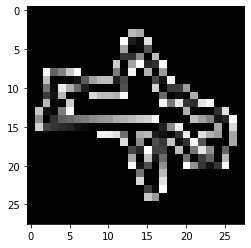

In [6]:
current_image = data_airplane[82,:]
current_image = current_image.reshape((28, 28)) * 255
plt.gray()
plt.imshow(current_image, interpolation='nearest')
plt.show()

In [7]:
data=pd.DataFrame(data)

In [8]:
j=0
i=0
label=[]
for i in range(120000):
    label.append(j)
    if j==1 or j==2:
        if (i+1)==30000 or (i+1)==50000:
            j+=1
        continue
    elif (i+1)%10000==0:
        j+=1
        

In [9]:
label=np.array(label)
label=np.reshape(label,(len(label),1))
label.shape
label=label.T
data=data.T
data =np.concatenate([data,label],axis=0)

In [10]:
data=data.T
data=data.astype('int64')

In [11]:
data.shape

(120000, 785)

In [12]:
k, l = data.shape
np.random.shuffle(data) # shuffle before splitting into dev and training sets

data_test = data[0:20000].T
Y_test = data_test[784]
X_test = data_test[0:l-1]
X_test = X_test / 255

data_train = data[20000:k].T
Y_train = data_train[784]
Y=Y_train
X_train = data_train[0:l-1]
X_train = X_train / 255


In [37]:
X_train.shape

(784, 100000)

In [14]:
def One_hot(Y):
    one_hot_Y = np.zeros((Y.size, Y.max() + 1))
    one_hot_Y[np.arange(Y.size), Y] = 1
    one_hot_Y = one_hot_Y.T
    return one_hot_Y
Y_train=One_hot(Y_train)
Y_test=One_hot(Y_test)

In [15]:
X_train.shape

(784, 100000)

In [16]:
training_data=(X_train,Y_train)

In [17]:
test_data=(X_test,Y_test)

In [18]:
len(training_data[1][0])

100000

In [19]:
#Creating the Network Class
class Network(object):
    def __init__(self,neurons):
        self.weights=[np.random.randn(y,x)/np.sqrt(x)for x,y in zip (neurons[:-1],neurons[1:])]
        self.bias=[np.random.randn(y,1)for y in neurons[1:]]
        self.layers=len(neurons)
        
    def SGD(self,training_data,learning_rate,epochs,mini_batch_size,lmbda=0,monitor_cost=False,test_accuracy=False,test_data=None):
        n=len(X_train[1])
        training_cost=[]
        training_accuracy=[]
        test=[]
        for i in range(epochs):
            m=0
            correct=0
            mini_batches=[(training_data[0][:,k:k+mini_batch_size],training_data[1][:,k:k+mini_batch_size]) 
                          for k in range(0,n,mini_batch_size)]
            for mini_batch in mini_batches:
                m=self.update_mini_batch(mini_batch,learning_rate,m,lmbda,n)
                
            if monitor_cost:
                cost=self.monitor_cost(training_data,lmbda)
                training_cost.append(cost)
            if test_accuracy:
                correct=self.evaluate(test_data,correct)
                test.append(correct)
            training_accuracy.append(m)
            print(f"Epoch:{i},Accuracy={(m/n)*100}")
        return training_cost,training_accuracy,test
                
    def update_mini_batch(self,mini_batch,learning_rate,m,lmbda,n):
        x_mini=mini_batch[0]
        y_mini=mini_batch[1]
        for x,y in zip(x_mini.T,y_mini.T):
            x=np.reshape(x,(len(x),1))
            y=np.reshape(y,(len(y),1))
            derivative_biases,derivative_weights,activations=self.backpropogation(x,y)
            self.weights=[(1-learning_rate*(lmbda/n))*w-(learning_rate*derivative_each_weight) 
                          for w,derivative_each_weight in zip(self.weights,derivative_weights)] #Updating the weights
            self.bias=[b-(learning_rate*derivative_each_bias) 
                       for b,derivative_each_bias in zip(self.bias,derivative_biases)] #Updating the biases
            prediction=self.get_predictions(activations[-1])
            m+=self.get_accuracy(prediction,y)
        return m
            
    def feedForward(self,x):
        activation=x 
        activations=[x] #Storing the values of input layer
        z_all=[]
        for w,b in zip(self.weights,self.bias):
            #Multiplying the 60 rows with 784 weight values with the input i.e each row of 784 is multiplied by the 784 input values 
            #and adding the bias value
            z=np.dot(w,activation)+b 
            z_all.append(z)
            activation=self.sigmoid(z)
            activations.append(activation)
        return activations,z_all
    
    def sigmoid(self,z):
        return 1.0/(1.0+np.exp(-z))
    
    def sigmoid_derivative(self,z):
        return self.sigmoid(z)*(1-self.sigmoid(z))
    
    def loss_function_derivative(self,Y_pred,Y_true):
        return(Y_pred-Y_true)
    
    def cross_entropy_function(self,a,Y_true):
        return np.sum(np.nan_to_num(-Y_true*np.log(a)-(1-Y_true)*np.log(1-a)))
    
    def derivative_cross_entropy(self,a,Y_true):
        return (a-Y_true)
    
    def backpropogation(self,x,y):
        derivative_biases=[np.zeros(b.shape) for b in self.bias]
        derivative_weights=[np.zeros(w.shape) for w in self.weights]
        activations,z_all=self.feedForward(x)
        loss_delta=self.derivative_cross_entropy(activations[-1],y)*self.sigmoid_derivative(z_all[-1])
        derivative_biases[-1]=loss_delta
        derivative_weights[-1]=np.dot(loss_delta,activations[-2].T)
        for layer in range(2,self.layers):
            loss_delta=np.dot(self.weights[-layer+1].T,loss_delta)*self.sigmoid_derivative(z_all[-layer])
            derivative_biases[-layer]=loss_delta
            derivative_weights[-layer]=np.dot(loss_delta,activations[-layer-1].T)
        return derivative_biases,derivative_weights,activations
    
    def get_predictions(self,a):
        return np.argmax(a,0)
    
    def get_accuracy(self,predictions,y):
        y=np.argmax(y)
        return np.sum(predictions==y)
    
    def monitor_cost(self,training_data,lmbda):
        cost=0.0
        x_all=training_data[0]
        y_all=training_data[1]
        for x,y in zip(x_all.T,y_all.T):
            x=np.reshape(x,(len(x),1))
            y=np.reshape(y,(len(y),1))
            activations,_=self.feedForward(x)
            #Calculating the cross entropy cost value
            cost+=self.cross_entropy_function(activations[-1],y)
        #Adding the regularization term to the cross entropy cost,The np.linalg.norm calculates the norm of the matrix,which is
        #the summation of all the terms in the matrix
        cost+=0.5*(lmbda/len(training_data[0][0]))*sum(np.linalg.norm(w)**2 for w in self.weights)
        return cost
    
    def evaluate(self,test_data,correct):
        x_test_all=test_data[0]
        y_test_all=test_data[1]
        for x,y in zip(x_test_all.T,y_test_all.T):
            x=np.reshape(x,(784,1))
            y=np.reshape(y,(10,1))
            k=self.make_predictions(x)
            m=np.argmax(y)
            if k==m:
                correct+=1
        return correct
    
    def make_predictions(self,x):
        activations,_=self.feedForward(x)
        return self.get_predictions(activations[-1])
        
    def save(self, filename):
        """Save the neural network to the file ``filename``."""
        data = {"sizes": self.layers,
                "weights": [w.tolist() for w in self.weights],
                "biases": [b.tolist() for b in self.bias],
                "cost": str(Cross_entropy_function)}
        f = open(filename, "w")
        json.dump(data, f)
        f.close()
            
        
            
        
            

In [20]:
def load(filename):
    """Load a neural network from the file ``filename``.  Returns an
    instance of Network.

    """
    f = open(filename, "r")
    data = json.load(f)
    f.close()
    #cost = getattr(sys.modules[__name__], data["cost"])
    net = Network(data["sizes"])
    net.weights = [np.array(w) for w in data["weights"]]
    net.biases = [np.array(b) for b in data["biases"]]
    return net

In [28]:
#learning_rates=[1.0,0.1,0.01]
lmbda=[10,1,0.1]
net=Network([784,50,100,10])
training_cost,training_accuracy,test_accuracy=net.SGD(training_data,0.01,15,10,10,monitor_cost=True,test_accuracy=True,test_data=test_data)


Epoch:0,Accuracy=40.900999999999996
Epoch:1,Accuracy=64.196
Epoch:2,Accuracy=69.77799999999999
Epoch:3,Accuracy=72.02300000000001
Epoch:4,Accuracy=73.546
Epoch:5,Accuracy=74.748
Epoch:6,Accuracy=75.742
Epoch:7,Accuracy=76.561
Epoch:8,Accuracy=77.31400000000001
Epoch:9,Accuracy=77.93299999999999
Epoch:10,Accuracy=78.428
Epoch:11,Accuracy=78.845
Epoch:12,Accuracy=79.216
Epoch:13,Accuracy=79.60300000000001
Epoch:14,Accuracy=79.972


In [ ]:
save("parameters.json")

In [ ]:
net1=load("parameters.json")

In [31]:
test_accuracy

array([11.689, 13.689, 14.23 , 14.581, 14.886, 15.094, 15.259, 15.385,
       15.514, 15.609, 15.686, 15.741, 15.793, 15.863, 15.91 ])

In [33]:
test_accuracy=np.array(test_accuracy)
test_accuracy=(test_accuracy/20000)*100
test_accuracy

array([58.445, 68.445, 71.15 , 72.905, 74.43 , 75.47 , 76.295, 76.925,
       77.57 , 78.045, 78.43 , 78.705, 78.965, 79.315, 79.55 ])

In [38]:
training_accuracy=np.array(training_accuracy)
training_accuracy=(training_accuracy/100000)*100
training_accuracy

array([40.901, 64.196, 69.778, 72.023, 73.546, 74.748, 75.742, 76.561,
       77.314, 77.933, 78.428, 78.845, 79.216, 79.603, 79.972])

In [178]:
def save(filename):
        """Save the neural network to the file ``filename``."""
        data = {"sizes": [784,60,30],
                "weights": [w.tolist() for w in net.weights],
                "biases": [b.tolist() for b in net.bias]}
        f = open(filename, "w")
        json.dump(data, f)
        f.close()

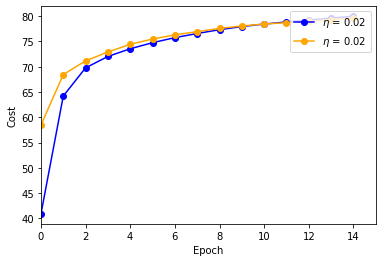

In [39]:
#for eta,training_costs in zip(learning_rates,training_cost):
fig = plt.figure()
ax = fig.add_subplot(111)
ax.plot(np.arange(15), training_accuracy, "o-",label="$\eta$ = "+str(0.02),color="blue")
ax.plot(np.arange(15), test_accuracy, "o-",label="$\eta$ = "+str(0.02),color="Orange")
ax.set_xlim([0, 15])
ax.set_xlabel('Epoch')
ax.set_ylabel('Cost')
plt.legend(loc='upper right')
plt.show()

In [40]:
def make_predictions(x):
    activations,_=net.feedForward(x)
    return net.get_predictions(activations[-1])

def test_prediction(index):
    index=index.astype('float64')
    x=index.reshape((784,1))
    x=x/255
    prediction=make_predictions(x)
    current_image=index
    sketch={
        0:"Eiffel Tower",
        1:"Airplane",
        2:"Apple",
        3:"bee",
        4:"cake",
        5:"car",
        6:"church",
        7:"Dolphin",
        8:"Dragon",
        9:"House"
    }
    return sketch[prediction[0]]
    

In [41]:
# import the time module
import time

# define the countdown func.
def countdown(t=25):
    
    sketch={
        0:"Eiffel Tower",
        1:"Airplane",
        2:"Apple",
        3:"bee",
        4:"cake",
        5:"car",
        6:"church",
        7:"Dolphin",
        8:"Dragon",
        9:"House"
    }
    c=random.randrange(0,10)
    return(sketch[c])

    while t:
        mins, secs = divmod(t, 60)
        timer = '{:02d}:{:02d}'.format(mins, secs)
        print(timer, end="\r")
        time.sleep(1)
        t -= 1
    


# input time in seconds
#t = input("Enter the time in seconds: ")
def call():
    t=25
    # function call
    for i in range(5):
        countdown(int(t))

In [42]:
def update(name):
    return f"Welcome to Gradio, {name}!"
with gr.Blocks() as demo:
    gr.Markdown("Press Start to play")
    with gr.Row():
        out = gr.Textbox()
    gr.Interface(fn=test_prediction,inputs="sketchpad",outputs="label",live=True)
    btn = gr.Button("Start")
    btn.click(fn=countdown,inputs=None, outputs=out)
demo.launch()

IMPORTANT: You are using gradio version 3.6, however version 3.14.0 is available, please upgrade.
--------
Hint: Set streaming=True for Sketchpad component to use live streaming.
Running on local URL:  http://127.0.0.1:7860

To create a public link, set `share=True` in `launch()`.


(<gradio.routes.App at 0x1dc3215b0a0>, 'http://127.0.0.1:7860/', None)